In [1]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# !pip install --quiet roboflow
!pip install --quiet ultralytics
!pip install --quiet opencv-python
!pip install --quiet vietocr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 793.6/793.6 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.3/21.3 MB 37.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.9/133.9 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.2/299.2 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 67.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 59.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 48.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.5/313.5 kB 24.9 MB/s eta 0:00:00


#OCR-Final


In [4]:
from matplotlib import pyplot as plt
from PIL import Image
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
from ultralytics import YOLO
import torch
import os

In [5]:
model = YOLO('/content/drive/MyDrive/OCR/Weights/yolo/train300/weights/best.pt')

In [40]:
# save_dir = "/content/drive/MyDrive/OCR/Cropped_Image"

In [7]:
def process_path(path):
  list_path = path.split("/")
  img_name = list_path[-1]
  name = img_name.split(".")[0]
  return name

In [8]:
class processImg:

  def __init__(self, image):
    # self.image = cv2.imread(img_path)
    self.image = image
    self.grayscale_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
    self.thresholded_image = cv2.threshold(self.grayscale_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
    self.inverted_image = cv2.bitwise_not(self.thresholded_image)
    self.dilated_image = cv2.dilate(self.inverted_image, None, iterations=1) # chỉnh iteration

  # def convert_image_to_grayscale(self): # chuyển xám
  #     self.grayscale_image = cv2.cvtColor(self.image, cv2.COLOR_BGR2GRAY)
  #     return self.grayscale_image

  # def threshold_image(self): #giữ pixel trắng và xám
  #     self.thresholded_image = cv2.threshold(self.grayscale_image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)[1]
  #     return self.thresholded_image

  # def invert_image(self):
  #     self.inverted_image = cv2.bitwise_not(self.thresholded_image)
  #     return self.inverted_image

  # def dilate_image(self):
  #     self.dilated_image = cv2.dilate(self.inverted_image, None, iterations=1) # chỉnh iteration
  #     return self.dilated_image

  def order_points(self, pts):
        pts = pts.reshape(4, 2)
        rect = np.zeros((4, 2), dtype="float32")
        s = pts.sum(axis=1)
        rect[0] = pts[np.argmin(s)]
        rect[2] = pts[np.argmax(s)]
        diff = np.diff(pts, axis=1)
        rect[1] = pts[np.argmin(diff)]
        rect[3] = pts[np.argmax(diff)]
        return rect

  def find_contours(self):
    contours, hierarchy = cv2.findContours(self.dilated_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # gray = process_img.convert_image_to_grayscale()
    # image_with_all_contours = gray.copy()
    # cv2.drawContours(image_with_all_contours, contours, -1, (0, 255, 0), 3)
    return contours, hierarchy

  def rec_contour(self):
    contours, hierarchy = self.find_contours()
    rectangular_contours = []
    for contour in contours:
        peri = cv2.arcLength(contour, True)
        approx = cv2.approxPolyDP(contour, 0.02 * peri, True)
        if len(approx) == 4:
            rectangular_contours.append(approx)
    # image_with_only_rectangular_contours = self.grayscale_image.copy()
    # rec_cont = cv2.drawContours(image_with_only_rectangular_contours, rectangular_contours, -1, (0, 255, 0), 3)
    return rectangular_contours

  def find_MaxContour(self):
    max_area = 0
    contour_with_max_area = None
    rectangular_contours = self.rec_contour()
    for contour in rectangular_contours:
        area = cv2.contourArea(contour)
        if area > max_area:
            max_area = area
            contour_with_max_area = contour
    # image_with_contour_with_max_area = gray.copy()
    # cv2.drawContours(image_with_contour_with_max_area, [contour_with_max_area], -1, (0, 255, 0), 3)
    return contour_with_max_area

  def calculateDistanceBetween2Points(self, p1, p2):
    dis = ((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2) ** 0.5
    return dis

  def angle_points(self):
    contour_with_max_area = self.find_MaxContour()
    contour_with_max_area_ordered = self.order_points(contour_with_max_area)
    # image_with_points_plotted = self.grayscale_image.copy()
    # for point in contour_with_max_area_ordered:
    #     point_coordinates = (int(point[0]), int(point[1]))
    #     image_with_points_plotted = cv2.circle(image_with_points_plotted, point_coordinates, 10, (0, 0, 255), -1)
    return contour_with_max_area_ordered

  def calculate_new_image_size(self):
    existing_image_width = self.grayscale_image.shape[1]
    contour_with_max_area_ordered = self.angle_points()
    existing_image_width_reduced_by_10_percent = int(existing_image_width * 0.9)
    distance_between_top_left_and_top_right = self.calculateDistanceBetween2Points(contour_with_max_area_ordered[0], contour_with_max_area_ordered[1])
    distance_between_top_left_and_bottom_left = self.calculateDistanceBetween2Points(contour_with_max_area_ordered[0], contour_with_max_area_ordered[3])
    aspect_ratio = distance_between_top_left_and_bottom_left / distance_between_top_left_and_top_right
    new_image_width = existing_image_width_reduced_by_10_percent
    new_image_height = int(new_image_width * aspect_ratio)
    return new_image_width, new_image_height

  def new_padded_perspective(self):
    contour_with_max_area_ordered = self.angle_points()
    new_image_width, new_image_height = self.calculate_new_image_size()
    pts1 = np.float32(contour_with_max_area_ordered)
    pts2 = np.float32([[0, 0], [new_image_width, 0], [new_image_width, new_image_height], [0, new_image_height]])
    matrix = cv2.getPerspectiveTransform(pts1, pts2)
    perspective_corrected_image = cv2.warpPerspective(self.grayscale_image, matrix, (new_image_width, new_image_height))
    image_height = self.grayscale_image.shape[0]
    padding = int(image_height * 0.1)
    perspective_corrected_image_padded = cv2.copyMakeBorder(perspective_corrected_image, padding, padding, padding, padding, cv2.BORDER_CONSTANT, value=[255, 255, 255])
    return perspective_corrected_image_padded

In [9]:
class linesRemover:
  def __init__(self, image_path): # tự hiểu là image
    self.image_path = image_path
    self.processed_obj = processImg(self.image_path)
    self.perpective_padded = self.processed_obj.new_padded_perspective()
    self.thresh_tb = cv2.threshold(self.perpective_padded, 180, 255, cv2.THRESH_BINARY)[1]
    self.invert_tb = cv2.bitwise_not(self.thresh_tb)

  def get_horizontal(self): # lấy đường ngang của bảng
    hor = np.array([[1,1,1,1,1,1]])
    vertical_lines_eroded_image = cv2.erode(self.invert_tb, hor, iterations=6)
    vertical_lines_eroded_image = cv2.dilate(vertical_lines_eroded_image, hor, iterations=15)
    return vertical_lines_eroded_image

  def get_vertical(self): # lấy đường dọc của bảng
    ver = np.array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]])
    horizontal_lines_eroded_image = cv2.erode(self.invert_tb, ver, iterations=2)
    horizontal_lines_eroded_image = cv2.dilate(horizontal_lines_eroded_image, ver, iterations=5)
    return horizontal_lines_eroded_image

  def subtract_line(self): #gộp đường dọc và ngang rồi xóa khỏi ảnh
    combined_image = cv2.add(self.get_horizontal(), self.get_vertical())
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    combined_image_dilated = cv2.dilate(combined_image, kernel, iterations=2)
    image_without_lines = cv2.subtract(self.invert_tb, combined_image_dilated)
    return image_without_lines

  def denoise_img(self): #giảm nhiễu
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
    image_without_lines_noise_removed = cv2.erode(self.subtract_line(), kernel, iterations=1)
    image_without_lines_noise_removed = cv2.dilate(image_without_lines_noise_removed, kernel, iterations=1)
    return image_without_lines_noise_removed


In [10]:
class TableProcess:
  def __init__(self, image_path): # tự hiểu là image
    self.image_path = image_path
    self.lineRm = linesRemover(self.image_path)
    self.image_without_lines = self.lineRm.denoise_img()
  def dilated(self):
    kernel_to_remove_gaps_between_words = np.array([
            [1,1],
            [1,1]
    ])
    dilated_image = cv2.dilate(self.image_without_lines, kernel_to_remove_gaps_between_words, iterations=1)
    simple_kernel = np.ones((5,5), np.uint8)
    dilated_image = cv2.dilate(dilated_image, simple_kernel, iterations=1)
    return dilated_image

  def drawBox(self): #trả về x, y,w,h của box chứa nội dung
    result = cv2.findContours(self.dilated(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    contours = result[0]
    # image_with_contours_drawn = grey_tb.copy()
    # cv2.drawContours(image_with_contours_drawn, contours, -1, (0, 255, 0), 1)
    bounding_boxes = []
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        bounding_boxes.append((x, y, w, h))
    bounding_boxes.sort(key = lambda x: x[0])
    return bounding_boxes

  # def croppedImg(self):
  #   bounding_boxes = self.drawBox()
  #   cropped_image = image[y:y+h, x:x+w]
  #   for idx, i in enumerate(bounding_boxes):
  #     cropped = display_img(grey_tb, i[0], i[1], i[2], i[3])
  #     # cropped_image_path = os.path.join(save_dir, f'table_{idx + 1}.jpg')
  #     cv2.imwrite(cropped_image_path, cropped)
  #     plt.imshow(cropped, cmap = 'gray')



In [49]:
from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg

In [47]:
class imgContent:

  def __init__(self, path, model):
    self.path = path
    self.model = model

  def loadModel(self): # load model ocr
    # load pretrained weight
    # config = Cfg.load_config_from_name('vgg_seq2seq')
    config = Cfg.load_config_from_name('vgg_transformer')
    # config['weights'] = '/content/drive/MyDrive/OCR/Weights/transformer/transformerocr1.pth'
    # set device to use cpu
    config['device'] = 'cpu'
    config['cnn']['pretrained']=True
    config['predictor']['beamsearch']=True
    detector = Predictor(config)
    # path = '/content/drive/MyDrive/002d12b31d85b2dbeb94.jpg'
    # img_cv2 = cv2.imread(path, cv2.IMREAD_UNCHANGED)

    # img_pil = Image.fromarray(np.uint8(img_cv2)).convert('RGB')

    # # Show image using cv2_imshow
    # cv2_imshow(img_cv2)
    return detector

  def prediction(self, arrPic): # dự đoán với dãy ảnh có dạng array
    # img_cv2 = cv2.imread(path, cv2.IMREAD_UNCHANGED)
    img_cv2 = arrPic
    img_pil = Image.fromarray(np.uint8(img_cv2)).convert('RGB')
    cv2_imshow(img_cv2)
    detector = self.loadModel()
    s = detector.predict(img_pil)
    return s

  def detect_information(self): # dùng yolo để detect nội dung
    data = {
        "TD": [],
        "ST": [],
        "DC": [],
        "B": []
    }
    key = list(data.keys())
    result = self.model.predict(self.path, conf = 0.55) # return to obj that include: boxes
    label = []
    coord = []
    for r in result[0]: # take the box x1,y1, x2,y2
      label.append(r.boxes.cls.numpy().astype(int)[0])
      coord.append(r.boxes.xyxy.numpy().astype(int)[0])

    ans = list(zip(label, coord))

    for i in ans:
      if key[i[0]] == "DC":
        data[key[i[0]]].append(i[1])
        data["DC"].sort(key = lambda x: x[0])
      elif key[i[0]] == "TD":
        data[key[i[0]]].append(i[1])
        data["TD"].sort(key = lambda x: x[0])
      elif key[i[0]] == "ST":
        data[key[i[0]]].append(i[1])
        data["ST"].sort(key = lambda x: x[0])
      else:
        data[key[i[0]]].append(i[1])
    return data

  def crop_image(self, path, data):
    img_name = process_path(path)
    img = cv2.imread(path, cv2.COLOR_BGR2RGB)
    temp = []
    if data is not None:
      # data co dang dict voi key = Name, value = point xy,x2y2
      for idx, (key, value) in enumerate(data.items()):
        if key == "B":
          for val in value:
            x1, y1, x2, y2 = val[0], val[1], val[2], val[3]
            crop_img = img[y1:y2, x1:x2]
            process = TableProcess(crop_img)
            bounding_boxes = process.drawBox()

            process_img = processImg(crop_img)
            process_img = process_img.new_padded_perspective()

            for idx, i in enumerate(bounding_boxes):
              cropped = process_img[i[1]:i[1]+i[3], i[0]:i[0]+i[2]]
              # cropped_image_path = os.path.join(save_dir, f'{img_name}_{key}_{idx + 1}.jpg')
              # cv2.imwrite(cropped_image_path, cropped)
              temp.append(cropped)
            cv2.rectangle(img, (x1,y1), (x2, y2), (255,255, 134), 2)
        else:
          for val in value:
            x1, y1, x2, y2 = val[0], val[1], val[2], val[3]
            crop_img = img[y1:y2, x1:x2]
            # cropped_image_path = os.path.join(save_dir, f'{img_name}_{key}_{idx + 1}.jpg')
            # cv2.imwrite(cropped_image_path, crop_img)
            cv2.rectangle(img, (x1,y1), (x2, y2), (255,255, 134), 2)
            temp.append(crop_img)
    cv2_imshow(img)
    return temp

  def getContent(self):
    data = self.detect_information()
    pictures = self.crop_image(self.path, data)
    for pic in pictures:
      p = self.prediction(pic)
      print(p)
    return pictures


image 1/1 /content/drive/MyDrive/OCR/Test/b3815d392cfb8fa5d6ea.jpg: 480x640 1 TD, 1 ST, 4 DCs, 304.3ms
Speed: 8.2ms preprocess, 304.3ms inference, 1.4ms postprocess per image at shape (1, 3, 480, 640)


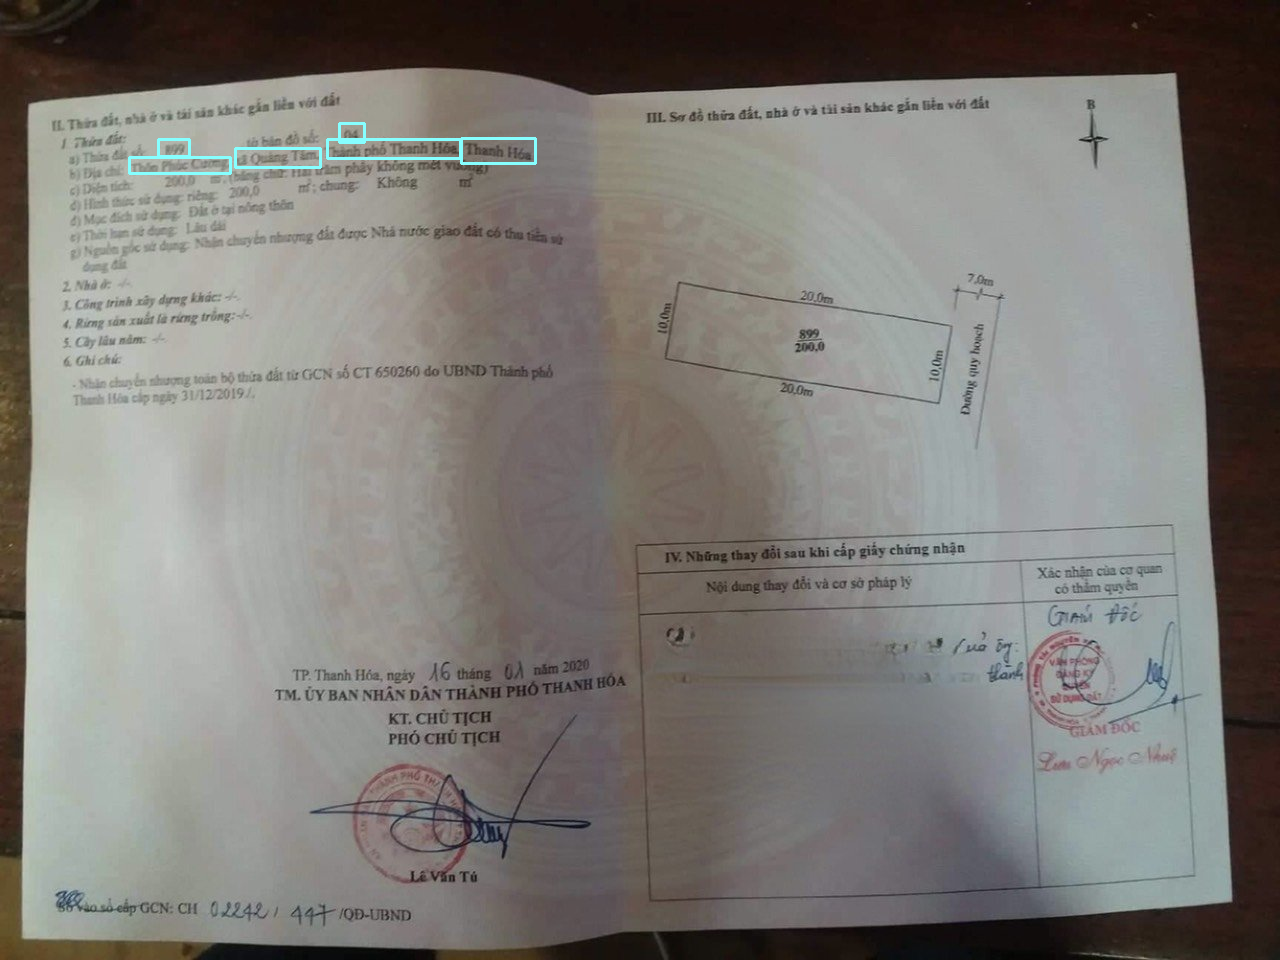

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Model weight /tmp/vgg_transformer.pth exsits. Ignore download!
Im


Model weight /tmp/vgg_transformer.pth exsits. Ignore download!
PM


Model weight /tmp/vgg_transformer.pth exsits. Ignore download!
Theo Phúc Cung


Model weight /tmp/vgg_transformer.pth exsits. Ignore download!
EQung Tim


Model weight /tmp/vgg_transformer.pth exsits. Ignore download!
Bình phố Thanh Hóa


Model weight /tmp/vgg_transformer.pth exsits. Ignore download!
Thanh Hóa


[array([[[255, 255, 134],
         [255, 255, 134],
         [255, 255, 134],
         ...,
         [255, 255, 134],
         [255, 255, 134],
         [255, 255, 134]],
 
        [[255, 255, 134],
         [255, 255, 134],
         [255, 255, 134],
         ...,
         [255, 255, 134],
         [255, 255, 134],
         [255, 255, 134]],
 
        [[255, 255, 134],
         [255, 255, 134],
         [172, 181, 178],
         ...,
         [168, 176, 175],
         [168, 176, 175],
         [255, 255, 134]],
 
        ...,
 
        [[255, 255, 134],
         [255, 255, 134],
         [170, 179, 176],
         ...,
         [165, 173, 172],
         [165, 173, 172],
         [255, 255, 134]],
 
        [[255, 255, 134],
         [255, 255, 134],
         [170, 179, 176],
         ...,
         [167, 173, 172],
         [168, 174, 173],
         [255, 255, 134]],
 
        [[255, 255, 134],
         [255, 255, 134],
         [255, 255, 134],
         ...,
         [255, 255, 134],
  

In [48]:
image_path = "/content/drive/MyDrive/OCR/Test/b3815d392cfb8fa5d6ea.jpg"
content = imgContent(image_path, model)
content.getContent()

#Code breakdown

In [25]:
# def save_image(path, data):
#   img_name = process_path(path)
#   img = cv2.imread(path, cv2.COLOR_BGR2RGB)

#   if data is not None:
#     # data co dang dict voi key = Name, value = point xy,x2y2
#     for idx, (key, value) in enumerate(data.items()):
#       if key == "B":
#         for val in value:
#           x1, y1, x2, y2 = val[0], val[1], val[2], val[3]
#           crop_img = img[y1:y2, x1:x2]
#           process = TableProcess(crop_img)
#           bounding_boxes = process.drawBox()

#           process_img = processImg(crop_img)
#           process_img = process_img.new_padded_perspective()

#           for idx, i in enumerate(bounding_boxes):
#             cropped = process_img[i[1]:i[1]+i[3], i[0]:i[0]+i[2]]
#             cropped_image_path = os.path.join(save_dir, f'{img_name}_{key}_{idx + 1}.jpg')
#             cv2.imwrite(cropped_image_path, cropped)
#           cv2.rectangle(img, (x1,y1), (x2, y2), (255,255, 134), 2)
#       else:

#         for val in value:
#           x1, y1, x2, y2 = val[0], val[1], val[2], val[3]
#           crop_img = img[y1:y2, x1:x2]
#           cropped_image_path = os.path.join(save_dir, f'{img_name}_{key}_{idx + 1}.jpg')
#           cv2.imwrite(cropped_image_path, crop_img)
#           cv2.rectangle(img, (x1,y1), (x2, y2), (255,255, 134), 2)
#   cv2_imshow(img)

In [29]:
def save_image(path, data):
  img_name = process_path(path)
  img = cv2.imread(path, cv2.COLOR_BGR2RGB)
  temp = []
  if data is not None:
    # data co dang dict voi key = Name, value = point xy,x2y2
    for idx, (key, value) in enumerate(data.items()):
      if key == "B":
        for val in value:
          x1, y1, x2, y2 = val[0], val[1], val[2], val[3]
          crop_img = img[y1:y2, x1:x2]
          process = TableProcess(crop_img)
          bounding_boxes = process.drawBox()

          process_img = processImg(crop_img)
          process_img = process_img.new_padded_perspective()

          for idx, i in enumerate(bounding_boxes):
            cropped = process_img[i[1]:i[1]+i[3], i[0]:i[0]+i[2]]
            # cropped_image_path = os.path.join(save_dir, f'{img_name}_{key}_{idx + 1}.jpg')
            # cv2.imwrite(cropped_image_path, cropped)
            temp.append(cropped)
          cv2.rectangle(img, (x1,y1), (x2, y2), (255,255, 134), 2)
      else:

        for val in value:
          x1, y1, x2, y2 = val[0], val[1], val[2], val[3]
          crop_img = img[y1:y2, x1:x2]
          # cropped_image_path = os.path.join(save_dir, f'{img_name}_{key}_{idx + 1}.jpg')
          # cv2.imwrite(cropped_image_path, crop_img)
          cv2.rectangle(img, (x1,y1), (x2, y2), (255,255, 134), 2)
          temp.append(crop_img)
  cv2_imshow(img)
  return temp

In [27]:
def detect_information(path, model):

  data = {
      "TD": [],
      "ST": [],
      "DC": [],
      "B": []
  }
  key = list(data.keys())
  result = model.predict(path, conf = 0.55) # return to obj that include: boxes
  label = []
  coord = []
  for r in result[0]: # take the box x1,y1, x2,y2
    label.append(r.boxes.cls.numpy().astype(int)[0])
    coord.append(r.boxes.xyxy.numpy().astype(int)[0])

  ans = list(zip(label, coord))

  for i in ans:
    if key[i[0]] == "DC":
      data[key[i[0]]].append(i[1])
      data["DC"].sort(key = lambda x: x[0])
    elif key[i[0]] == "TD":
      data[key[i[0]]].append(i[1])
      data["TD"].sort(key = lambda x: x[0])
    elif key[i[0]] == "ST":
      data[key[i[0]]].append(i[1])
      data["ST"].sort(key = lambda x: x[0])
    else:
      data[key[i[0]]].append(i[1])
  return data

In [41]:
image_path = "/content/drive/MyDrive/OCR/Test/b3815d392cfb8fa5d6ea.jpg"

In [ ]:
# ansss = TableProcess(image_path)
# ansss.drawBox()

In [42]:
data = detect_information(image_path, model)


image 1/1 /content/drive/MyDrive/OCR/Test/b3815d392cfb8fa5d6ea.jpg: 480x640 1 TD, 1 ST, 4 DCs, 233.1ms
Speed: 10.0ms preprocess, 233.1ms inference, 2.0ms postprocess per image at shape (1, 3, 480, 640)


In [43]:
data

{'TD': [array([158, 139, 189, 156])],
 'ST': [array([339, 123, 364, 142])],
 'DC': [array([129, 157, 230, 173]),
  array([235, 148, 320, 167]),
  array([327, 139, 460, 158]),
  array([461, 138, 535, 163])],
 'B': []}

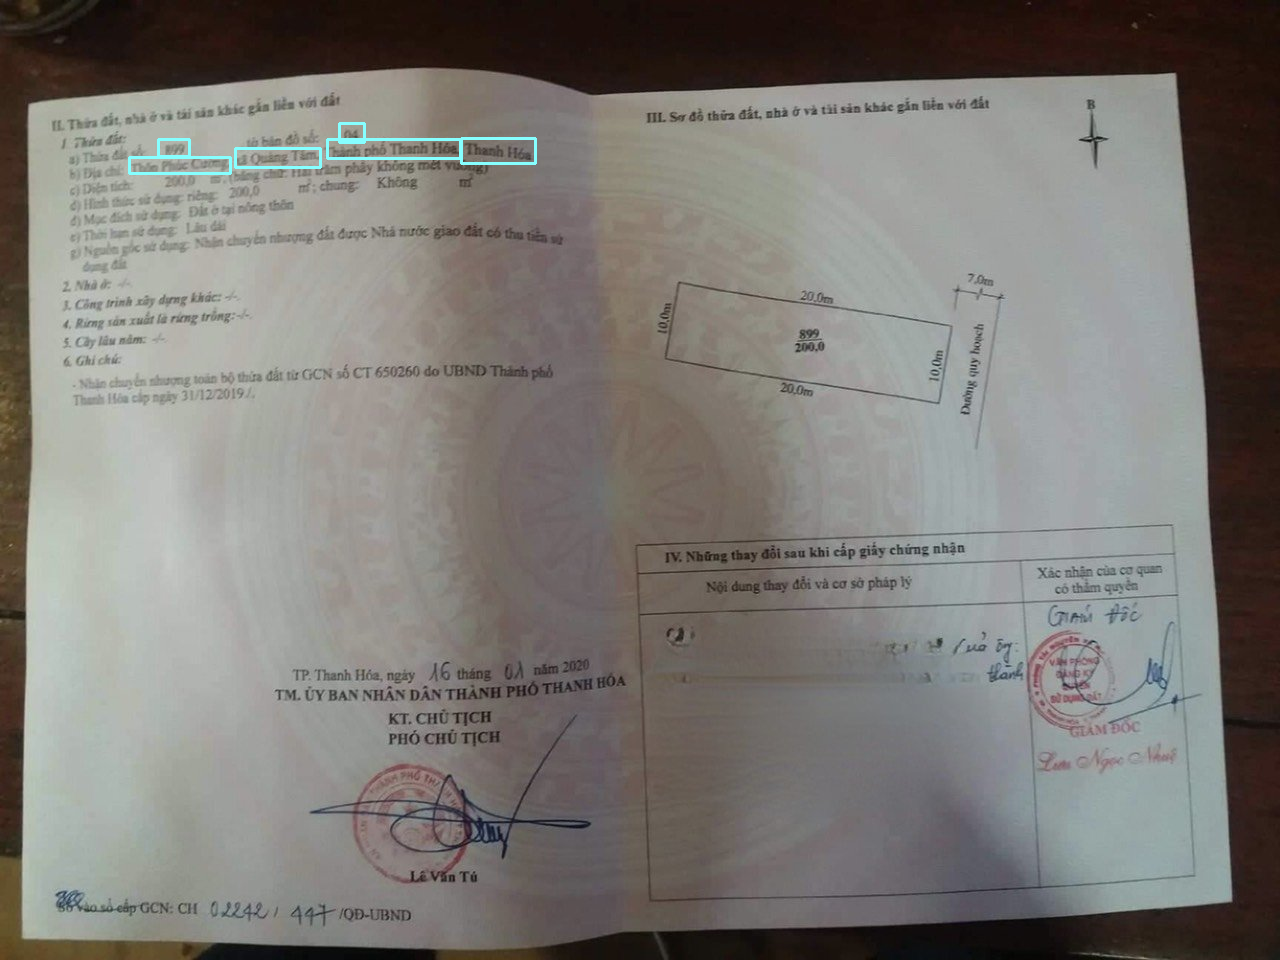

6


In [44]:
pictures = save_image(image_path, data)
print(len(pictures))

In [17]:
from vietocr.tool.predictor import Predictor
from vietocr.tool.config import Cfg

In [18]:
# load pretrained weight

# config = Cfg.load_config_from_name('vgg_seq2seq')
config = Cfg.load_config_from_name('vgg_transformer')
# config['weights'] = '/content/drive/MyDrive/OCR/Weights/transformer/transformerocr1.pth'

# set device to use cpu
config['device'] = 'cpu'
config['cnn']['pretrained']=True
config['predictor']['beamsearch']=True

detector = Predictor(config)

# path = '/content/drive/MyDrive/002d12b31d85b2dbeb94.jpg'
# img_cv2 = cv2.imread(path, cv2.IMREAD_UNCHANGED)

# img_pil = Image.fromarray(np.uint8(img_cv2)).convert('RGB')

# # Show image using cv2_imshow
# cv2_imshow(img_cv2)


Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth
100%|██████████| 548M/548M [00:04<00:00, 116MB/s]
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
18533it [00:16, 1146.73it/s]


In [45]:
def predict(arrPic):
  # img_cv2 = cv2.imread(path, cv2.IMREAD_UNCHANGED)
  img_cv2 = arrPic
  img_pil = Image.fromarray(np.uint8(img_cv2)).convert('RGB')
  cv2_imshow(img_cv2)
  s = detector.predict(img_pil)
  return s

In [46]:
for pic in pictures:
    # img_path = os.path.join(save_dir, img_file)
    p = predict(pic)
    print(p)

Im


PM


Theo Phúc Cung


EQung Tim


Bình phố Thanh Hóa


Thanh Hóa


In [36]:
# image_files = [f for f in os.listdir(save_dir) if f.endswith('.jpg')]

# for img_file in image_files:
#     img_path = os.path.join(save_dir, img_file)
#     p = predict(img_path)
#     print(p)